<a href="https://colab.research.google.com/github/nivedita-rajesh/BasalGanglia/blob/main/Final_DQN_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
import numpy as np
import tensorflow as tf
from google.colab import drive
import os
import joblib
from datetime import datetime

drive.mount('/content/drive')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "1"

Mounted at /content/drive


In [ ]:
class BasalGangliaMDP(gym.Env):
    def __init__(self):
        super().__init__()

        # Define states
        self.states = ['Cortex', 'Striatum', 'GPe', 'STN', 'GPi', 'Thalamus']

        # Define actions
        self.actions = ["activation", "inhibition"]
        self.action_space = gym.spaces.Discrete(len(self.actions))

        self.transition_probs = {
            "Cortex": {
                "activation": { "Striatum": 1.0 },
                "inhibition": { "Striatum": 1.0 }
            },
            "Striatum": {
                "inhibition": { 'GPe': 0.5, 'GPi': 0.5 },
            },
            "GPe": {
                "inhibition": { "STN": 1.0 },
            },
            "STN": {
                "activation": { "GPi": 1.0 },
            },
            "GPi": {
                "inhibition": { "Thalamus": 1.0 },
            },
            "Thalamus": {
                "activation": { "Cortex": 1.0 },
            }
        }

        self.rewards = {
            ("Cortex", "activation", "Striatum") : 1.0,
            ("Cortex", "inhibition", "Striatum") : 1.0,

            ("Striatum", "inhibition", "GPe") : 1.0,
            ("Striatum", "inhibition", "GPi") : 1.0,

            ("GPe", "inhibition", "STN") : 1.0,

            ("STN", "activation", "GPi") : 1.0,

            ("GPi", "inhibition", "Thalamus") : 1.0,

            ("Thalamus", "activation", "Cortex") : 1.0
        }

        self.state = 'Cortex'  # Initial state

    def calculate_rewards(self, state, action, next_state, dopamine, acetyl, levodopa):
          if(dopamine <= 39.6 and acetyl > 2.5 and levodopa < 100):
            if(state == "Cortex" and next_state == "Striatum"):
              if(action == "activation"):
                return self.rewards.get((self.state, action, next_state), 0) * -100
              elif(action == "inhibition"):
                return self.rewards.get((self.state, action, next_state), 0) * 250

            elif(state=="Striatum" and next_state=="GPe"):
                return self.rewards.get((self.state, action, next_state), 0) * 400

            elif(state=="Striatum" and next_state=="GPi"):
                return self.rewards.get((self.state, action, next_state), 0) * -250

            elif(state=="GPe" and next_state=="STN"):
                return self.rewards.get((self.state, action, next_state), 0) * 500

            elif(state=="STN" and next_state=="GPi"):
                return self.rewards.get((self.state, action, next_state), 0) * 600

            elif(state=="GPi" and next_state=="Thalamus"):
                return self.rewards.get((self.state, action, next_state), 0) * 800

            else:
                raise Exception("Get good bro")


          elif(dopamine <= 39.6 and acetyl > 2.5 and levodopa >= 100 and levodopa <=250):
            if(state == "Cortex" and next_state == "Striatum"):
              if(action == "activation"):
                return self.rewards.get((self.state, action, next_state), 0) * 200

              elif(action == "inhibition"):
                return self.rewards.get((self.state, action, next_state), 0) * -150

            elif(state=="Striatum" and next_state=="GPe"):
                return self.rewards.get((self.state, action, next_state), 0) * -200

            elif(state=="Striatum" and next_state=="GPi"):
                return self.rewards.get((self.state, action, next_state), 0) * 450

            elif(state=="GPe" and next_state=="STN"):
                return self.rewards.get((self.state, action, next_state), 0) * -300

            elif(state=="STN" and next_state=="GPi"):
                return self.rewards.get((self.state, action, next_state), 0) * -350

            elif(state=="GPi" and next_state=="Thalamus"):
                return self.rewards.get((self.state, action, next_state), 0) * 1000

            else:
                raise Exception("Get good bro")


          elif(dopamine > 39.6 and dopamine <= 195.8 and acetyl >=0.5 and acetyl <= 2.5):
            if(state == "Cortex" and next_state == "Striatum"):
              if(action == "activation"):
                return self.rewards.get((self.state, action, next_state), 0) * 200

              elif(action == "inhibition"):
                return self.rewards.get((self.state, action, next_state), 0) * -150

            elif(state=="Striatum" and next_state=="GPe"):
                return self.rewards.get((self.state, action, next_state), 0) * -200

            elif(state=="Striatum" and next_state=="GPi"):
                return self.rewards.get((self.state, action, next_state), 0) * 550

            elif(state=="GPe" and next_state=="STN"):
                return self.rewards.get((self.state, action, next_state), 0) * -300

            elif(state=="STN" and next_state=="GPi"):
                return self.rewards.get((self.state, action, next_state), 0) * -350

            elif(state=="GPi" and next_state=="Thalamus"):
                return self.rewards.get((self.state, action, next_state), 0) * 1000

            else:
                raise Exception("Get good bro")


    def step(self, action, dopamine, acetyl, levodopa):

        next_state_probs = self.transition_probs[self.state][action]
        next_state = np.random.choice(list(next_state_probs.keys()), p=list(next_state_probs.values()))

        # reward = self.rewards.get((self.state, action, next_state), 0)

        reward = self.calculate_rewards(self.state, action, next_state, dopamine, acetyl, levodopa)

        self.state = next_state

        done = next_state == 'Thalamus'  # Terminal state
        info = {}

        return next_state, reward, done, info

    def reset(self):
        self.state = 'Cortex'
        return self.state

    def render(self):
        print(self.state)

In [ ]:
class DQNAgent:
    def __init__(self, state_space_size, action_space_size, learning_rate=0.001, discount_factor=0.9, exploration_prob=0.9):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob

        # Build Q-network
        self.q_network = self.build_q_network()

        # Target Q-network (for stability)
        self.target_q_network = self.build_q_network()
        self.target_q_network.set_weights(self.q_network.get_weights())

        # Optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

        # Experience replay buffer
        self.memory = []

    def build_q_network(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(self.state_space_size,), dtype=tf.float32),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.action_space_size)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def select_action(self, state):
      if np.random.rand() < self.exploration_prob:
          return np.random.choice(self.action_space_size)
      else:
          # Convert state index to one-hot encoding
          state_one_hot = np.zeros(self.state_space_size)
          state_one_hot[state] = 1

          # Reshape state for model prediction
          state_one_hot = state_one_hot.reshape(1, -1)  # Reshape to (1, state_space_size)

          # Predict Q-values for the current state
          q_values = self.q_network.predict(state_one_hot)

          # Select action with the highest Q-value
          return np.argmax(q_values[0])

    def update_q_network(self, batch_size, states=None):
      if len(self.memory) < batch_size:
          return

      if states is None:
          # Sample a batch from memory
          samples = np.random.choice(len(self.memory), batch_size, replace=False)
          batch = [self.memory[i] for i in samples]

          # Extract components from the batch
          states, actions, rewards, next_states, dones = zip(*batch)

          # Convert state indices to one-hot encoding
          states = np.eye(len(env.states), dtype=int)[np.array(states)]

          q_values = self.q_network.predict(states)
          next_q_values = self.target_q_network.predict(states)

          # Update Q-values based on Bellman equation
          for i in range(batch_size):
              target = rewards[i] + self.discount_factor * np.max(next_q_values[i]) * (1 - dones[i])
              q_values[i, actions[i]] = target

          # Train the Q-network
          self.q_network.fit(states, q_values, verbose=0)

    def update_target_network(self):
        self.target_q_network.set_weights(self.q_network.get_weights())

In [ ]:
# dopamine values for training
dvalues_range1 = np.random.uniform(0, 39.5, 5000)
dvalues_range2 = np.random.uniform(39.5, 195.8, 5000)
dvalues_range3 = np.random.uniform(39.5, 195.8, 5000)
dopamine_values = np.concatenate((dvalues_range1, dvalues_range2, dvalues_range3))
#np.random.shuffle(dopamine_values)

# acetylcholine values
avalues_range1 = np.random.uniform(2.5,5 , 5000)
avalues_range2 = np.random.uniform(0.5, 2.5, 5000)
avalues_range3 = np.random.uniform(0.5, 2.5, 5000)
acetyl_values = np.concatenate((avalues_range1, avalues_range2, avalues_range3))
#np.random.shuffle(acetyl_values)

# levodopa values
lvalues_range1 = np.random.uniform(0,100 , 5000)
lvalues_range2 = np.random.uniform(100,250, 5000)
lvalues_range3 = np.random.uniform(100,250, 5000)
levodopa_values = np.concatenate((lvalues_range1, lvalues_range2, lvalues_range3))
#np.random.shuffle(acetyl_values)

In [ ]:
# Instantiate the environment and the DQN agent
env = BasalGangliaMDP()
agent = DQNAgent(state_space_size=len(env.states), action_space_size=env.action_space.n)

# Training the DQN agent
num_episodes = 15000
batch_size = 32

for episode in range(num_episodes):

    state_episode = []
    total_reward = 0

    dopamine_value = dopamine_values[episode]
    acetyl_value= acetyl_values[episode]
    levodopa_value=levodopa_values[episode]


    state = env.reset()
    state_episode.append(state)

    print(f"\nEpisode {episode + 1}:")

    while True:
        # Convert state to its corresponding index
        state_index = env.states.index(state)

        action = agent.select_action(state_index)

        # making sure only existing actions is taken.
        while((env.actions[action] not in env.transition_probs[state])):
          action = agent.select_action(state_index)

        next_state, reward, done, _ = env.step(env.actions[action], dopamine_value,acetyl_value,levodopa_value)

        print(f"Transition: {env.states[state_index]} -> {next_state}, Reward: {reward}")

        # Convert next_state to its corresponding index
        next_state_index = env.states.index(next_state)

        # Store experience in replay buffer
        agent.memory.append((state_index, action, reward, next_state_index, done))

        # Update Q-network
        if len(state_episode) >= 2:
            agent.update_q_network(batch_size, states=state_episode)

        if reward is not None:
          total_reward += reward
        state = next_state

        if done:
            break

        # Add more states to the state_episode list
        if len(state_episode) < 10:
            state_episode.append(state)
        else:
            # Remove the first state in the state_episode list
            state_episode.pop(0)
            # Add the current state to the state_episode list
            state_episode.append(state)

    # Update target network periodically
    if episode % 10 == 0:
        agent.update_target_network()

    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

Streaming output truncated to the last 5000 lines.
Episode 14351:
Transition: Cortex -> Striatum, Reward: -150.0
Transition: Striatum -> GPe, Reward: -200.0
Transition: GPe -> STN, Reward: -300.0
Transition: STN -> GPi, Reward: -350.0
1/1 [==============================] - 0s 33ms/step
Transition: GPi -> Thalamus, Reward: 1000.0
Episode: 14351, Total Reward: 0.0

Episode 14352:
Transition: Cortex -> Striatum, Reward: 200.0
Transition: Striatum -> GPe, Reward: -200.0
Transition: GPe -> STN, Reward: -300.0
Transition: STN -> GPi, Reward: -350.0
Transition: GPi -> Thalamus, Reward: 1000.0
Episode: 14352, Total Reward: 350.0

Episode 14353:
Transition: Cortex -> Striatum, Reward: -150.0
Transition: Striatum -> GPi, Reward: 550.0
Transition: GPi -> Thalamus, Reward: 1000.0
Episode: 14353, Total Reward: 1400.0

Episode 14354:
Transition: Cortex -> Striatum, Reward: 200.0
Transition: Striatum -> GPe, Reward: -200.0
Transition: GPe -> STN, Reward: -300.0
1/1 [==============================] - 

In [ ]:
!pip install dill

import dill

# saving the whole model object.
with open("/content/drive/MyDrive/BASAL/dqn_agent.pkl", "wb") as f:
  dill.dump(agent, f)

with open("/content/drive/MyDrive/BASAL/env.pkl", "wb") as f:
  dill.dump(env, f)

In [ ]:
# Loading the model
with open("/content/drive/MyDrive/BASAL/dqn_agent.pkl", "rb") as f:
    loaded_agent = dill.load(f)

with open("/content/drive/MyDrive/BASAL/env.pkl", "rb") as f:
    loaded_env = dill.load(f)

In [ ]:
# Testing the model
no_iterations = 1000
direct_array = ["Cortex", "Striatum", "GPi", "Thalamus"]
indirect_array = ["Cortex", "Striatum", "GPe", "STN", "GPi", "Thalamus"]
accuracy_array = []

for i in range(no_iterations):

    # Testing the trained DQN agent
    state = loaded_env.reset()
    done = False

    output_array = [state]

    dopamine_value = np.random.uniform(0, 195.8, 1)[0]
    acetyl_value = np.random.uniform(0.5, 5, 1)[0]
    levodopa_value = np.random.uniform(0, 250, 1)[0]

    print("\ndopamine : ", dopamine_value, ", acetyl:",acetyl_value, ", levo: ", levodopa_value)

    # Reset exploration probability to 0.1 during testing phase
    loaded_agent.exploration_prob = 0.1

    print(i, " Finally chosen pathway: ")

    while not done:

        # Convert state to its corresponding index
        state_index = loaded_env.states.index(state)

        action = loaded_agent.select_action(state_index)

        # making sure only existing actions is taken.
        while ((loaded_env.actions[action] not in loaded_env.transition_probs[state])):
            action = loaded_agent.select_action(state_index)

        next_state, reward, done, _ = loaded_env.step(
            loaded_env.actions[action], dopamine_value, acetyl_value, levodopa_value)

        print(
            f"Transition: {loaded_env.states[state_index]} -> {next_state}, Reward: {reward}")

        output_array.append(next_state)

        state = next_state

    if (dopamine_value < 39.5):

        if (output_array == indirect_array):
            accuracy_array.append(True)
        else:
            accuracy_array.append(False)

    elif (dopamine_value > 39.6 and dopamine_value < 195.8):

        if (output_array == direct_array):
            accuracy_array.append(True)
        else:
            accuracy_array.append(False)

print("-------------------------------------------------------------")
print("Accuracy: ", (accuracy_array.count(True)/len(accuracy_array)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 67ms/step
Transition: STN -> GPi, Reward: -350.0
Transition: GPi -> Thalamus, Reward: 1000.0

dopamine :  59.11248471159978 , acetyl: 3.7353260972572926 , levo:  180.69132210018964
760  Finally chosen pathway: 
1/1 [==============================] - 0s 35ms/step
Transition: Cortex -> Striatum, Reward: None
1/1 [==============================] - 0s 45ms/step
Transition: Striatum -> GPi, Reward: None
1/1 [==============================] - 0s 38ms/step
Transition: GPi -> Thalamus, Reward: None

dopamine :  52.0257092164917 , acetyl: 2.6534982347962375 , levo:  152.4403654138508
761  Finally chosen pathway: 
1/1 [==============================] - 0s 33ms/step
Transition: Cortex -> Striatum, Reward: None
1/1 [==============================] - 0s 47ms/step
Transition: Striatum -> GPi, Reward: None
1/1 [==============================] - 0s 51ms/step
Transition: GPi -> Thalamus, Reward: None

dopamine 


dopamine :  42.85597463437375


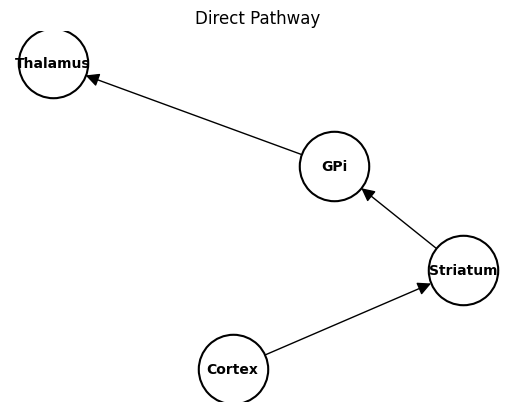

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the pathways
direct_pathway_edges = [("Cortex", "Striatum"), ("Striatum", "GPi"), ("GPi", "Thalamus")]
indirect_pathway_edges = [("Cortex", "Striatum"), ("Striatum", "GPe"), ("GPe", "STN"), ("STN", "GPi"), ("GPi", "Thalamus")]
on=""

# Create a graph
G = nx.DiGraph()

# Add edges for direct pathway
G.add_edges_from(direct_pathway_edges)

# Add edges for indirect pathway
G.add_edges_from(indirect_pathway_edges)

# Testing the trained DQN agent
state = loaded_env.reset()
done = False

output_array = [state]

dopamine_value = np.random.uniform(0,196)
acetyl_value = np.random.uniform(0,5)
levodopa_value = np.random.uniform(0,250)
print("\ndopamine : ", dopamine_value)

while not done:
    # Convert state to its corresponding index
    state_index = loaded_env.states.index(state)

    action = loaded_agent.select_action(state_index)

    # making sure only existing actions are taken.
    while ((loaded_env.actions[action] not in loaded_env.transition_probs[state])):
            action = loaded_agent.select_action(state_index)

    next_state, reward, done, _ = loaded_env.step(
            loaded_env.actions[action], dopamine_value, acetyl_value, levodopa_value)
    #print(f"Transition: {env.states[state_index]} -> {next_state}, Reward: {reward}")

    output_array.append(next_state)

    state = next_state

# Create a directed graph
output_graph = nx.DiGraph()

# Add nodes and edges based on the output array
for i in range(len(output_array) - 1):
    output_graph.add_edge(output_array[i], output_array[i+1])

# Check conditions and visualize the graph accordingly
if dopamine_value < 39.5:
    if output_array == indirect_array:
        on="1"
        plt.title("Indirect Pathway")
        nx.draw(output_graph, with_labels=True, node_size=2500, node_color="white", edgecolors="black", linewidths=1.5, font_size=10, font_weight="bold", arrowsize=20)
    else:
        print("Pathway not found.")

elif dopamine_value > 39.6 and dopamine_value < 195.8:
    if output_array == direct_array:
        om="0"
        plt.title("Direct Pathway")
        nx.draw(output_graph,with_labels=True, node_size=2500, node_color="white", edgecolors="black", linewidths=1.5, font_size=10, font_weight="bold", arrowsize=20)
    else:
        print("Pathway not found.")

plt.show()


In [ ]:
import pandas as pd

# Read the text file into a DataFrame
df_pd = pd.read_csv('/content/drive/MyDrive/BASAL/dummyGeneActiveData_Day1.txt', delimiter='\t')
df_nonpd = pd.read_csv("/content/drive/MyDrive/BASAL/dummyPebbleData_Day1.txt", delimiter="\t")

# Calculate the average for each column
average_values_pd = df_pd.mean()
average_values_nonpd = df_nonpd.mean()

# Display the average values
print("Average values:")
print(average_values_nonpd)

Average values:
timestamp           1.429522e+09
Pebble_X           -5.528709e-01
Pebble_Y            1.485991e-01
Pebble_Z           -9.669751e+00
Pebble_Magnitude    9.692960e+00
dtype: float64


In [ ]:
# final ouput from the model
if(output_array == indirect_array):
  print(f"x: {average_values_pd[1]}, y: {average_values_pd[2]}, z: {average_values_pd[3]}")
elif(output_array == direct_array):
  print(f"x: {average_values_nonpd[1]}, y: {average_values_nonpd[2]}, z: {average_values_nonpd[3]}")

x: -0.5528708847336269, y: 0.1485990549217123, z: -9.669750824849604


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
